In [1]:
import numpy as np
import matplotlib.pyplot as plt

# fitness function

- $c_{fr}$ : follow rail coefficient
- $c_{s}$ : safety coefficient
- $c_{pc}$ : pedestrian coefficient
- $c_{t}$ : trajectory coefficient

$$
f = c_{fr} \cdot R_c + c_{s} \cdot R_s + c_{pc} \cdot R_{pc} + c_{t} \cdot R_t
$$

$f \in [-4,4]$


### Rail following
- $d_p$ : penalty distance
- $d$ : distance between the train and the rail

$$
R_c = 1-\frac{2}{1+e^{-d + d_p}}
$$

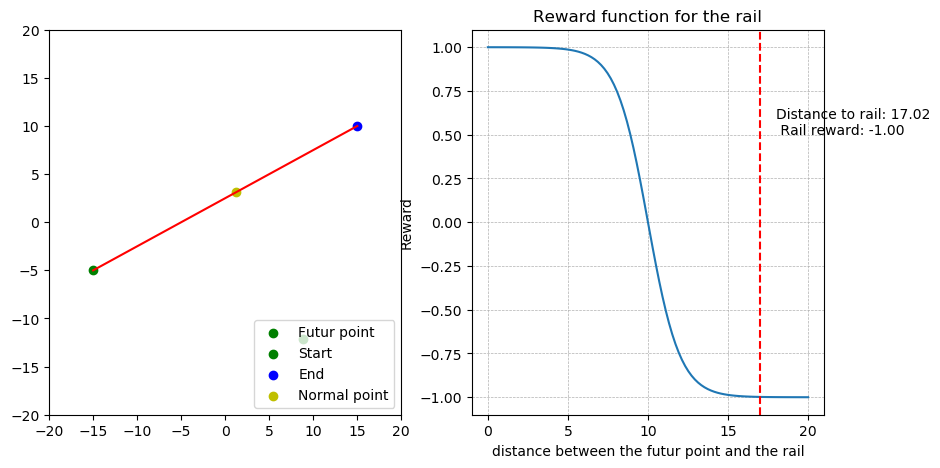

In [2]:
max_distance_display = 20
d = np.linspace(0, max_distance_display, 100)
penalty_distance = 10
Rc =1-2 / (1 + np.exp(-d + penalty_distance))
fig , ax = plt.subplots(1, 2 , figsize=(10, 5))

ax[1].plot(d, Rc)
ax[1].set_xlabel('distance between the futur point and the rail')
ax[1].set_ylabel('Reward')
ax[1].set_title('Reward function for the rail')
ax[1].xaxis.set_ticks(np.arange(0, max_distance_display+1, 5))
ax[1].grid(True, linewidth=0.5, linestyle='--')

path = np.array([[-15, -5], [15, 10]])
futur_point = np.random.uniform(-15, 15, 2)
# vector a is start point to futur point
a = futur_point - path[0]
# vector b is start point to end point
b = path[1] - path[0]
# d is the product of the magnitude of a and cos of the angle between a and b
d = np.linalg.norm(a) * np.cos(np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))))
normal_point = path[0] + d * b / np.linalg.norm(b)
distance_to_rail = np.linalg.norm(futur_point - normal_point)
Rc = 1 - 2 / (1 + np.exp(-distance_to_rail + penalty_distance))
ax[1].axvline(distance_to_rail, color='r', linestyle='--')
ax[1].annotate(f'Distance to rail: {distance_to_rail:.2f}\n Rail reward: {Rc:.2f}',
                (distance_to_rail + 1, 0.5))

ax[0].plot(path[:, 0], path[:, 1], 'r')
ax[0].scatter(futur_point[0], futur_point[1], c='g', label='Futur point')
ax[0].scatter(path[0, 0], path[0, 1], c='g', label='Start') 
ax[0].scatter(path[1, 0], path[1, 1], c='b', label='End')
ax[0].scatter(normal_point[0], normal_point[1], c='y', label='Normal point')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].legend(loc='lower right')
plt.show()

### Motion safety
- $eval_{radius}$ : evaluation radius
- $nb_{p}$ : number of pedestrians in the evaluation radius
- $d_i$ : distance between the vehicle and the i-th pedestrian
- $d_p$ : penalty distance


$$
S_c = -1 + \frac{2}{1+e^{-\frac{\sum_{i=1}^{nb_{p}}d_i}{d_i} + d_p}}
$$

or 

$$
S_c = -1 + \frac{2}{1+e^{-\bar{d_i} + d_p}}
$$

Lowess distance: 6.49
Mean distance: 10.54


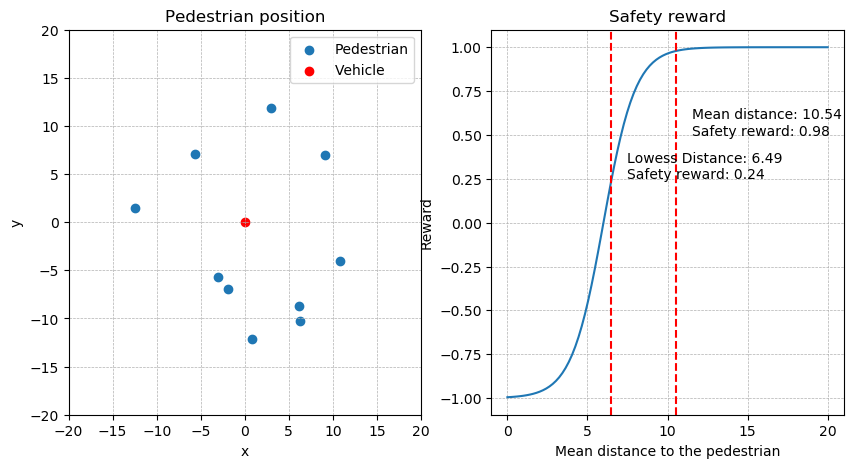

In [32]:
def safety_reward(distance, penalty_distance):
    return 2 / (1 + np.exp(-distance + penalty_distance)) - 1

eval_radius = 20
nb_pedestrian = 10
mu = 2.5 # in meter
# radom direction from the vehicle
random_vector = np.random.uniform(-np.pi, np.pi, (2, nb_pedestrian))
random_vector = np.array([np.cos(random_vector[0]), np.sin(random_vector[1])])
# normalize the vector
random_vector /= np.linalg.norm(random_vector, axis=0)
# random distance
d = np.random.randn(nb_pedestrian) * mu + eval_radius/2
# random position
pedestrian_pos = d * random_vector

penalty_distance = 6
mean_distance = np.mean(d)
lowess_distance = d[np.argmin(np.abs(d))]

print(f'Lowess distance: {lowess_distance:.2f}\nMean distance: {mean_distance:.2f}')
linspace_distance = np.linspace(0, eval_radius, 100)
Sc = safety_reward(linspace_distance, penalty_distance)

fig, axe = plt.subplots(1, 2, figsize=(10, 5))

axe[0].scatter(pedestrian_pos[0], pedestrian_pos[1], label='Pedestrian')
axe[0].scatter(0, 0, c='r', label='Vehicle')
axe[0].set_title('Pedestrian position')
axe[0].set_xlabel('x')
axe[0].set_ylabel('y')
axe[0].grid(True, linewidth=0.5, linestyle='--')
axe[0].legend()
axe[0].set_xlim(-eval_radius, eval_radius)
axe[0].set_ylim(-eval_radius, eval_radius)

axe[1].plot(linspace_distance, Sc)
axe[1].set_title('Safety reward')
axe[1].set_xlabel('Mean distance to the pedestrian')
axe[1].set_ylabel('Reward')
axe[1].grid(True, linewidth=0.5, linestyle='--')
axe[1].axvline(mean_distance, color='r', linestyle='--', label='Mean distance')
axe[1].annotate(f'Mean distance: {mean_distance:.2f}\nSafety reward: {safety_reward(mean_distance,penalty_distance):.2f}',
                (mean_distance + 1, 0.5))
axe[1].axvline(lowess_distance, color='r', linestyle='--', label='Lowess distance')
axe[1].annotate(f'Lowess Distance: {lowess_distance:.2f}\nSafety reward: {safety_reward(lowess_distance,penalty_distance):.2f}',
                (lowess_distance + 1, 0.0))

plt.show()

### Trajectory Quality
- $|a|$ : magnitude of the acceleration
- $m_0$ : magniture zero limit


$$
|a| = \sqrt{\frac{dx^2}{dt^2} + \frac{dy^2}{dt^2}}
$$

$$
T_c = 1 - \frac{2}{1+e^{-|a| + m_0}}
$$

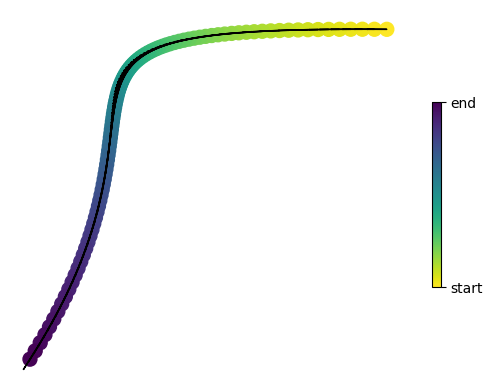

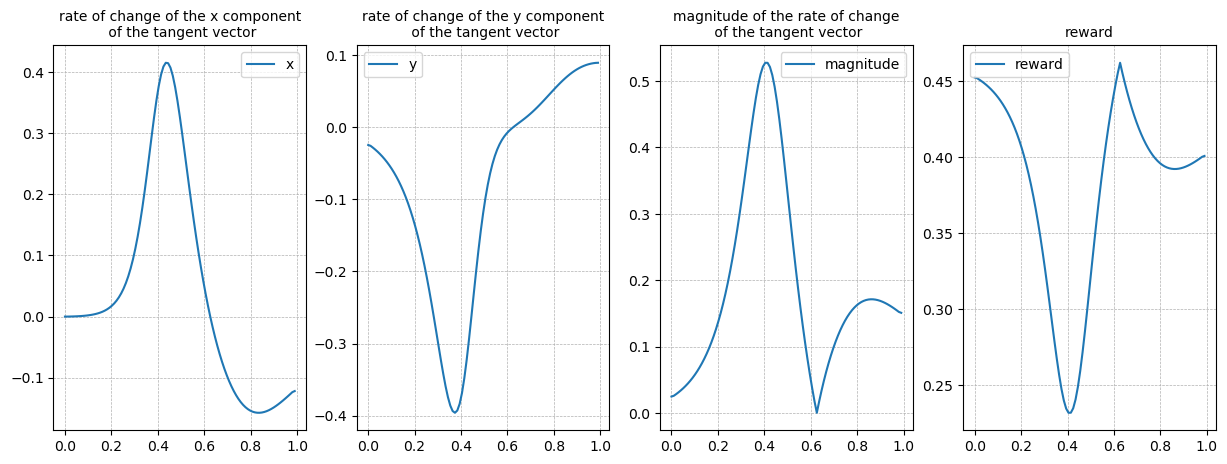

In [7]:
def lerp (a, b ,t):
    return a*(1-t) + b*t

# np.random.seed(42)

P1 = np.random.randn(2)
P2 = np.random.randn(2)
P3 = np.random.randn(2)
P4 = np.random.randn(2)

n = 100

l = np.linspace(0, 1, n).reshape(-1, 1)

P5 = lerp(P1, P2, l)
P6 = lerp(P2, P3, l)
P7 = lerp(P3, P4, l)
P8 = lerp(P5, P6, l)
P9 = lerp(P6, P7, l)
P10 = lerp(P8, P9, l)

# the tangent vector at each point
tangent = np.diff(P10, axis=0)
# normalize the tangent
tangent = tangent / np.linalg.norm(tangent, axis=1).reshape(-1, 1)
tangent *= 0.1


plt.scatter(P10[:, 0], P10[:, 1], c=l.flatten(), cmap = 'viridis_r', label='v',s=100)
for i in range(len(P10) - 1):
    plt.arrow(P10[i, 0], P10[i, 1], tangent[i, 0], tangent[i, 1])
plt.axis('off')
clor = plt.colorbar(shrink=0.5)
clor.set_ticks([0, 1])
clor.set_ticklabels(['start', 'end'])

plt.show()
dxdl = np.gradient(tangent[:, 0], l[:-1].flatten())
dydl = np.gradient(tangent[:, 1], l[:-1].flatten())


magnitude_roc = np.sqrt(dxdl**2 + dydl**2)
esp = 0.0001
# reward  = 1 / (magnitude_roc + esp)
maginture_zero_limit = 1
reward = -2 / (1 + np.exp(-magnitude_roc + maginture_zero_limit)) +1

fig, axe = plt.subplots(1, 4, figsize=(15, 5))
axe[0].plot(l[:-1], dxdl, label='x')
axe[0].set_title('rate of change of the x component\n of the tangent vector', fontsize=10)
axe[0].grid(True, linewidth=0.5, linestyle='--')
axe[0].legend()


axe[1].plot(l[:-1], dydl, label='y')
axe[1].set_title('rate of change of the y component\n of the tangent vector', fontsize=10)
axe[1].grid(True, linewidth=0.5, linestyle='--')
axe[1].legend()

axe[2].plot(l[:-1], magnitude_roc, label='magnitude')
axe[2].set_title('magnitude of the rate of change\n of the tangent vector', fontsize=10)
axe[2].grid(True, linewidth=0.5, linestyle='--')
axe[2].legend()

axe[3].plot(l[:-1], reward, label='reward')
axe[3].set_title('reward', fontsize=10)
axe[3].grid(True, linewidth=0.5, linestyle='--')
axe[3].legend()


plt.show()

# plt.plot(tangent[:, 0], tangent[:, 1])
# plt.scatter(0, 0, c='r', label='start')
# plt.show()

### Pedestrian Comfort
- $\bar{I}_{ucf}$ : frequency of the linear velocity change a pedestrian experienced during the navigation
- $f_0$ : frequency zero penalmagniture


$$
T_c = 1 - \frac{2}{1+e^{10(-\bar{I}_{ucf} + m_0)}}
$$

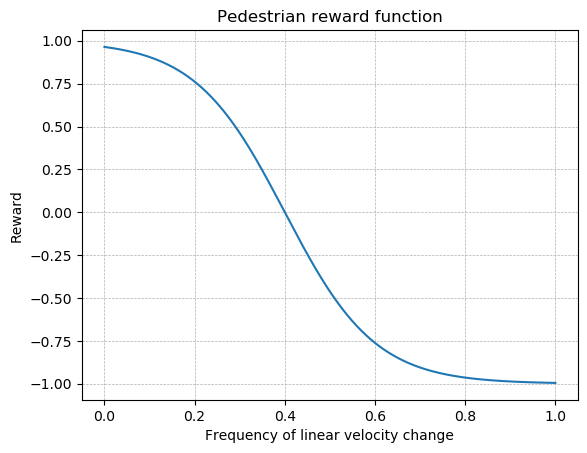

In [8]:
freq_domain = np.linspace(0, 1, 1000)
freq_penalty = 0.4

Pc = -2 / (1 + np.exp(10*(-freq_domain + freq_penalty))) + 1

plt.plot(freq_domain, Pc)
plt.xlabel('Frequency of linear velocity change')
plt.ylabel('Reward')
plt.title('Pedestrian reward function')
plt.grid(True, linewidth=0.5, linestyle='--')
plt.show()


## pedestrian density

In [104]:
nb_pedestrian = 30
pedestrian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))
density_grid = np.zeros((80, 80))
for i in range(pedestrian_pos.shape[1]):
    x = int((pedestrian_pos[0, i] + 20) * 2)
    y = int((pedestrian_pos[1, i] + 20) * 2)
    density_grid[x, y] += np.exp(-np.linalg.norm([x, y] - pedestrian_pos[:, i]))
density_grid /= nb_pedestrian
density_grid = np.rot90(density_grid)


In [114]:
nb_pedestrian = 100
pedestrian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))
density_grid = np.zeros((100, 100))
for i in range(density_grid.shape[0]):
    for j in range(density_grid.shape[1]):
        x = -20 + i * 0.4
        y = -20 + j * 0.4
        for k in range(nb_pedestrian):
            density_grid[i, j] += np.exp(-np.linalg.norm([x, y] - pedestrian_pos[:, k]))
density_grid /= nb_pedestrian
density_grid = np.rot90(density_grid)


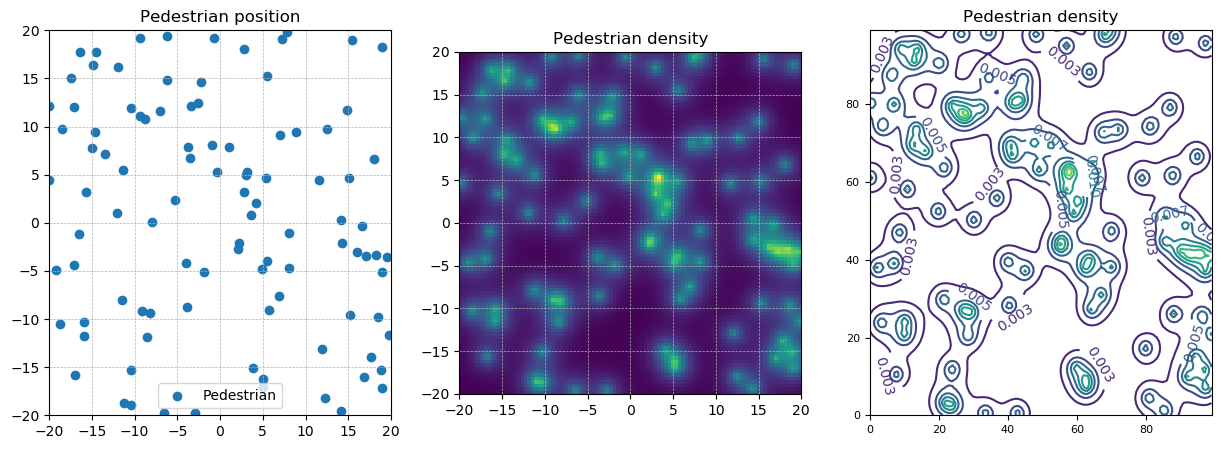

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(pedestrian_pos[0], pedestrian_pos[1], label='Pedestrian')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].set_title('Pedestrian position')
ax[0].grid(True, linewidth=0.5, linestyle='--')
ax[0].legend()

ax[1].imshow(density_grid, cmap='viridis', extent=(-20, 20, -20, 20))
ax[1].set_xlim(-20, 20)
ax[1].set_ylim(-20, 20)
ax[1].set_title('Pedestrian density')
ax[1].grid(True, linewidth=0.5, linestyle='--')

density_grid = np.rot90(density_grid.T)
cs = plt.contour(density_grid, cmap='viridis')
ax[2].clabel(cs, inline=1, fontsize=10)
# ax[2].axis('off')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('Pedestrian density')
plt.show()


In [112]:
occupancy_grid = np.zeros((16, 16))
nb_pedestrian = 100
pedestrian_pos = np.random.uniform(-20, 20, (2, nb_pedestrian))

for i in range(pedestrian_pos.shape[1]):
    x = int((pedestrian_pos[0, i] + 20) // 3)
    y = int((pedestrian_pos[1, i] + 20) // 3)
    occupancy_grid[x, y] += 1

occupancy_grid = np.rot90(occupancy_grid)

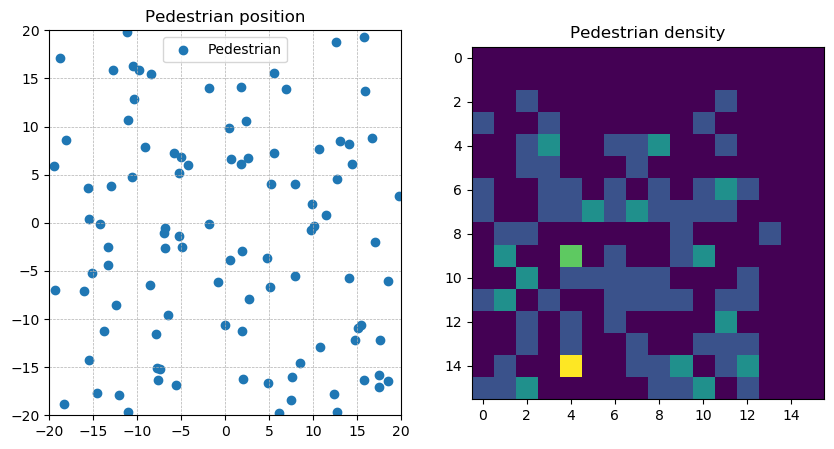

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(pedestrian_pos[0], pedestrian_pos[1], label='Pedestrian')
ax[0].set_xlim(-20, 20)
ax[0].set_ylim(-20, 20)
ax[0].set_title('Pedestrian position')
ax[0].grid(True, linewidth=0.5, linestyle='--')
ax[0].legend()

ax[1].imshow(occupancy_grid, cmap='viridis', interpolation='nearest')
ax[1].set_title('Pedestrian density')
# ax[1].grid(True, linewidth=0.5, linestyle='--')
plt.show()